# basic torch training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from resnet34 import *
from torchsummary import summary
from tqdm import tqdm

/home/hexagon/miniconda3/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# cifar10
batch_size = 64
num_train = 10000

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset = torch.utils.data.Subset(trainset, range(num_train))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet34(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model, (3, 32, 32))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]           4,160
       BatchNorm2d-9             [-1, 64, 8, 8]             128
           Conv2d-10             [-1, 64, 8, 8]           4,160
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
            Block-13             [-1, 64, 8, 8]               0
           Conv2d-14            

In [4]:
# training loop
for epoch in range(20): 
    with tqdm(trainloader, unit="batch") as tepoch:

        running_loss = 0.0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data).to(device)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            # calculating accuracy
            predictions = outputs.argmax(dim=1, keepdim=True)
            correct = (predictions == target).sum().item()
            accuracy = correct / batch_size

            # print statistics
            tepoch.set_postfix(loss=loss.item(), accuracy=100.*accuracy)

print('Finished Training')

Epoch 19: 100%|██████████| 157/157 [00:04<00:00, 38.30batch/s, accuracy=64.1, loss=0.792]

Finished Training


In [5]:
# saving
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  cat   ship  ship  plane


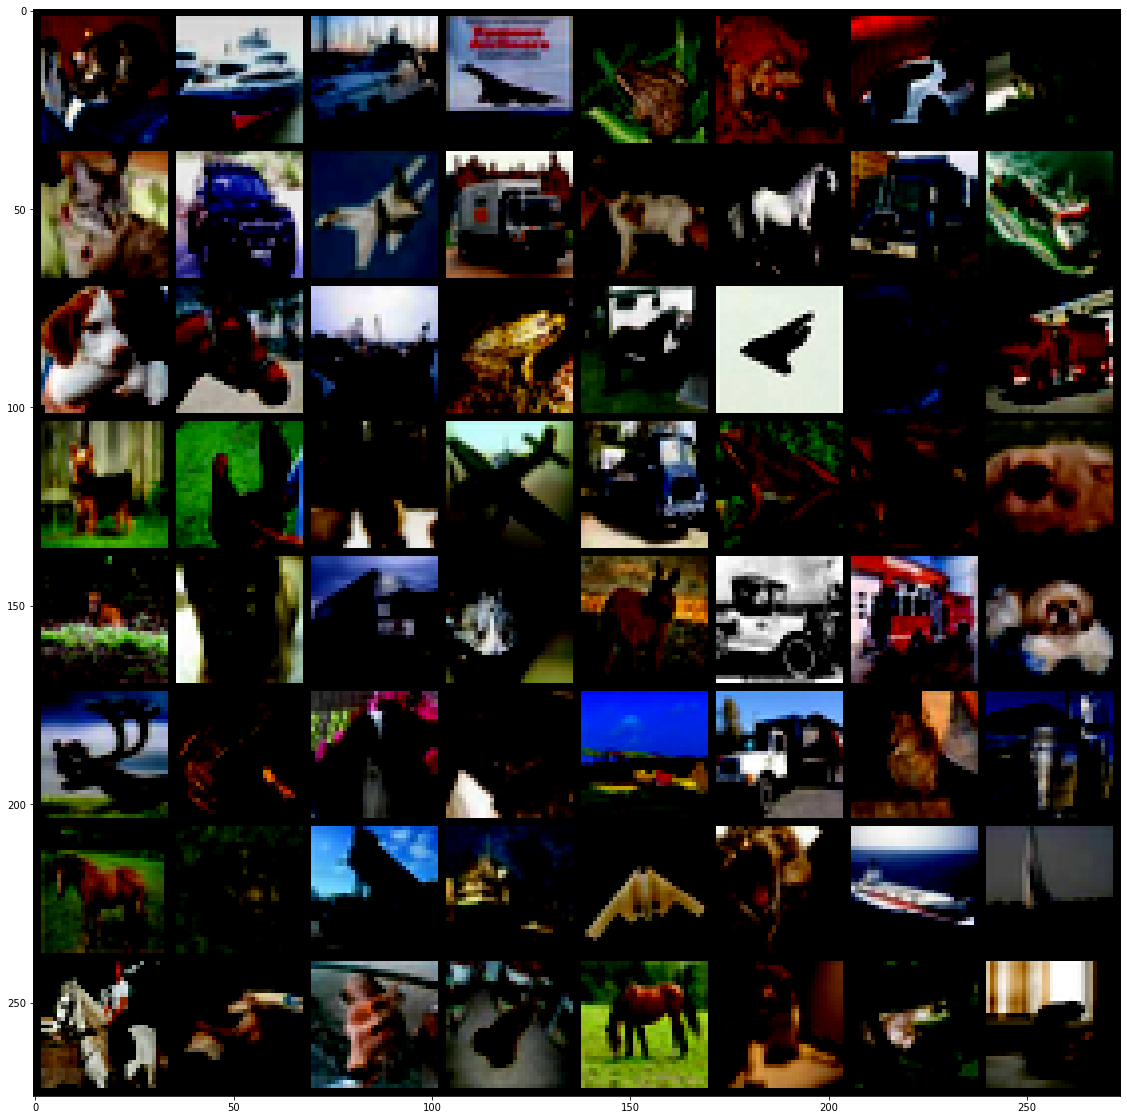

In [14]:
# testing
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print images
plt.figure(figsize=(20,20))
plt.imshow(torchvision.utils.make_grid(images.cpu()).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))